In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from os.path import expanduser
HOME = expanduser("~")
import os
import cv2

In [7]:
animal = 'DK55'
section = 164
INPUT = os.path.join(HOME, 'programming/brains', animal, str(section))
INPUT = '/Users/yoavfreund/projects/cell_detection_data/sections/%d'%section
!ls $INPUT
INPUT

164.csv             tile-0.tif          tile-4.tif          tile-8.tif
164.tif             tile-1.tif          tile-5.tif          tile-9.tif
extracted_cells.pkl tile-2.tif          tile-6.tif
puntas.csv          tile-3.tif          tile-7.tif


'/Users/yoavfreund/projects/cell_detection_data/sections/164'

### Tiles info
the original images are width=60000, height=34000.

Ed: I think either tile 5 or 7 would contain lots of premotor cells
the original images are width=60000, height=34000. 

#### Tile organzation

5 rows (height/5), 2 columns (width/2)

In [8]:
width = 60000
height = 34000
tile_height = int(height / 5)
tile_width=int(width/2)
print('width=%d, tile_width=%d ,height=%d, tile_height=%d'%(width, tile_width,height,tile_height))
origins={}
for i in range(10):
    row=int(i/2)
    col=i%2
    origins[i] = (row*tile_height,col*tile_width)
print('origins=',origins)

width=60000, tile_width=30000 ,height=34000, tile_height=6800
origins= {0: (0, 0), 1: (0, 30000), 2: (6800, 0), 3: (6800, 30000), 4: (13600, 0), 5: (13600, 30000), 6: (20400, 0), 7: (20400, 30000), 8: (27200, 0), 9: (27200, 30000)}


In [9]:
%%time
tile=5
file = 'tile-%d.tif'%tile
radius = 400
color = (2000)
infile = os.path.join(INPUT, file)
img = cv2.imread(infile, -1)
img.shape

CPU times: user 517 ms, sys: 637 ms, total: 1.15 s
Wall time: 1.73 s


(6800, 30000)

In [12]:
# for using tile = 5, we push the origin down 2 tile_heights

dfpath = os.path.join(INPUT, '%d.csv'%section)
df = pd.read_csv(dfpath)
df.shape

(70, 4)

In [13]:
in_row_min=5400; in_row_max=6800; in_col_min=8000; in_col_max=13000
#in_row_min=0; in_row_max=6800; in_col_min=0; in_col_max=30000
vimg=img[in_row_min:in_row_max, in_col_min: in_col_max]

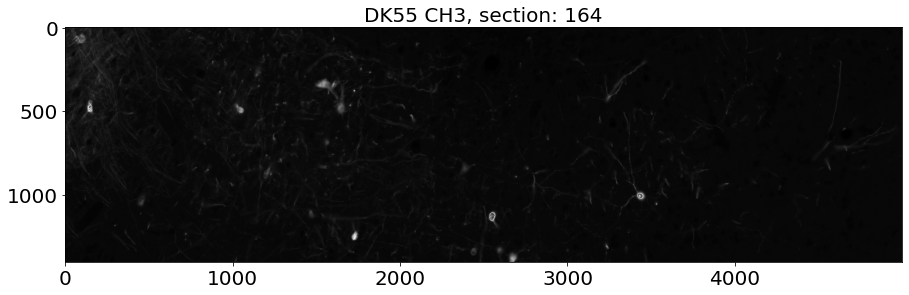

In [14]:
def show_image(img,_title="",fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()
show_image(4*vimg,_title=f'{animal} CH3, section: {section}')

In [15]:
def collect_positives(uimg):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (6000)
    min_row,min_col = origins[tile]
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 2)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives

In [16]:
annotated_img,positives=collect_positives(img)

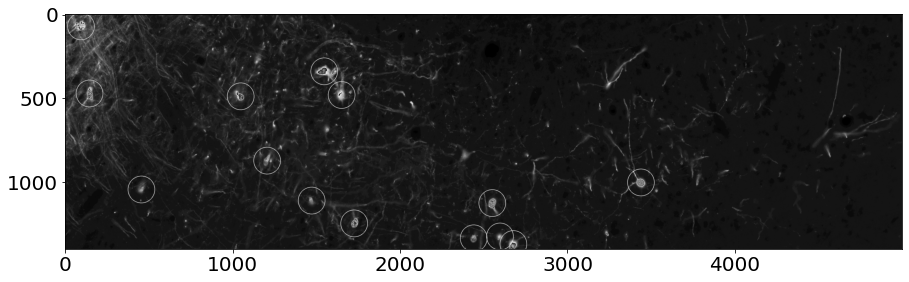

In [17]:
vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(vimg*10)


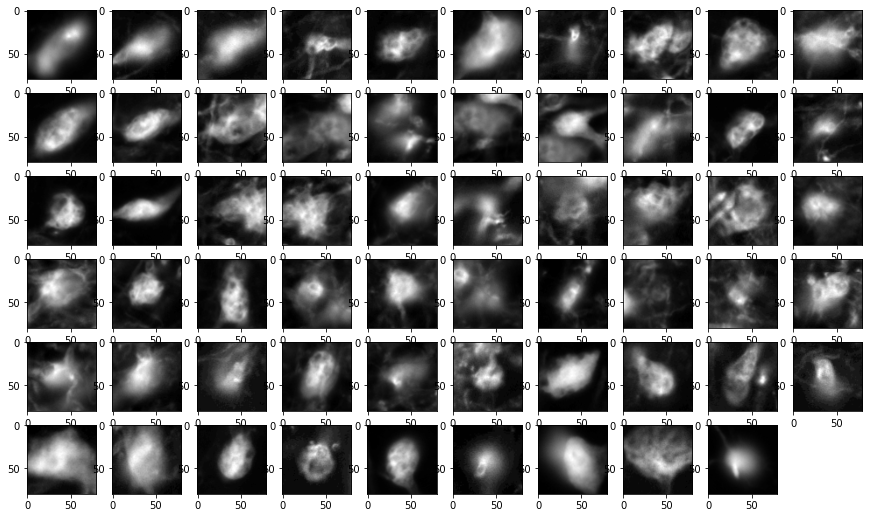

In [18]:
plt.figure(figsize=[15,15])
for i in range(len(positives)):
    plt.subplot(10,10,i+1)
    plt.imshow(positives[i][2], cmap="gray")
plt.show()

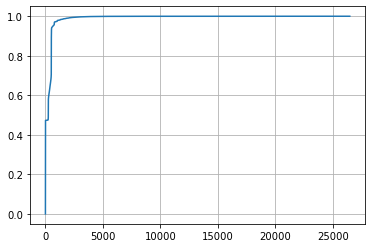

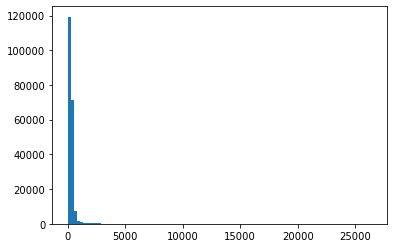

In [19]:
def plot_dist(uimg):
    H=uimg.flatten()
    H=np.sort(H)

    H=H[0:-1:1000]

    plt.plot(H,np.arange(0,1,1./H.shape[0]))
    plt.grid()
    plt.figure()
    plt.hist(H,bins=100);
plot_dist(img)

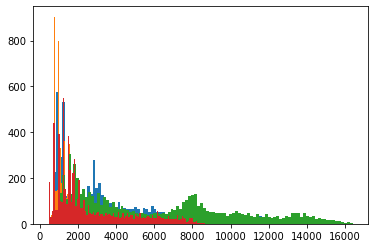

In [26]:
for i in [10,20,30,40]:
    plt.hist(positives[i][2].flatten(),bins=100);

In [29]:
positives[0]

(14627,
 5771,
 array([[ 514,  514,  514, ...,  996, 1016, 1107],
        [ 514,  514,  514, ..., 1030, 1103, 1254],
        [ 514,  514,  514, ..., 1003, 1227, 1282],
        ...,
        [ 420,  343,  521, ...,  776,  711,  660],
        [ 516,  505,  519, ...,  771,  778,  783],
        [ 514,  514,  514, ...,  780,  781,  782]], dtype=uint16))

In [30]:
for i in range(len(positives)):
    _shape=positives[i][2].shape
    if _shape !=(80,80):
        print(i,_shape)

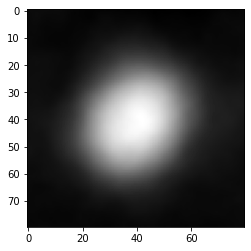

-rw-r--r--  1 yoavfreund  staff    2351149 Aug 13 21:56 BoostedTrees.pkl
-rw-r--r--  1 yoavfreund  staff  837047074 Aug 14 15:58 examples.pkl
-rw-r--r--  1 yoavfreund  staff      51362 Aug 19 13:23 mean.pkl


In [31]:
S=np.stack([I for (x,y,I)in positives])
S.shape

Mean=np.mean(S,axis=0)
Mean.shape

plt.imshow(Mean, cmap="gray")
plt.show()

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
_mean,_std

Mean = (Mean-_mean)/_std

import pickle as pk
with open('mean.pkl','wb') as pkl_file:
    pk.dump({'Mean':Mean},pkl_file)

!ls -l *.pkl

In [23]:
# from scipy.signal import convolve2d

In [24]:
# O=convolve2d(uimg,Mean,mode='valid') #takes forevr, might be better with GPU

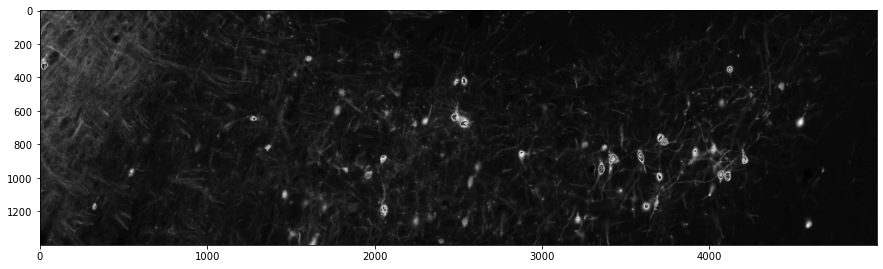

In [25]:
plt.figure(figsize=[15,15])
UPimg=uimg[in_row_min:in_row_max, in_col_min: in_col_max]
plt.imshow(5*UPimg,cmap='gray');

<Figure size 1080x1080 with 0 Axes>

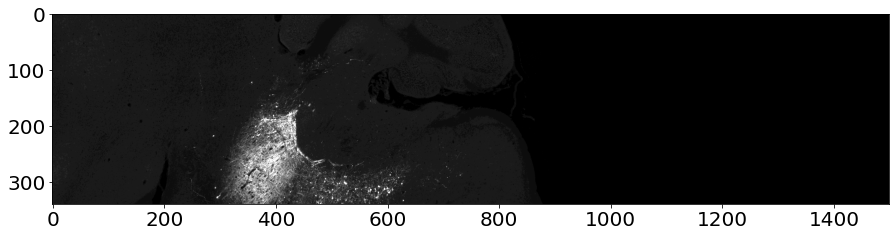

In [56]:
plt.figure(figsize=[15,15])
small=cv2.resize(S,(0,0),fx=0.05,fy=0.05)
show_image(small);

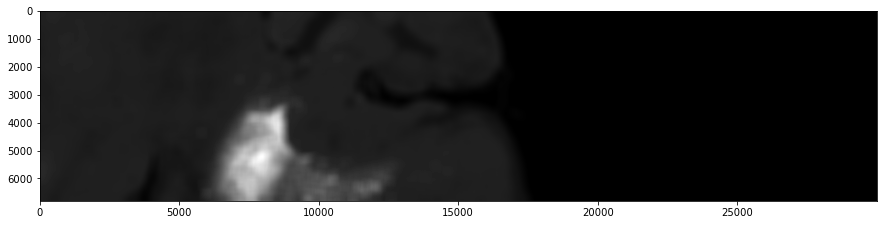

In [57]:
blur=cv2.GaussianBlur(small,ksize=(21,21),sigmaX=10)
relarge=cv2.resize(blur,(0,0),fx=20,fy=20) #,interpolation=cv2.INTER_AREA)
plt.figure(figsize=[15,15])
plt.imshow(relarge,cmap='gray');

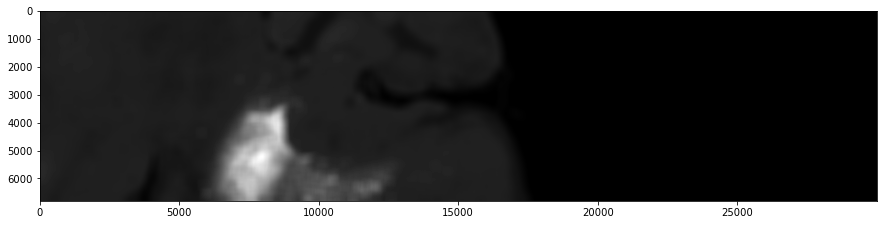

In [51]:
relarge=cv2.resize(blur,(0,0),fx=20,fy=20) #,interpolation=cv2.INTER_AREA)
plt.figure(figsize=[15,15])
plt.imshow(relarge,cmap='gray');

In [58]:
blur.shape,uimg_8bit.shape,relarge.shape

((340, 1500), (6800, 30000), (6800, 30000))

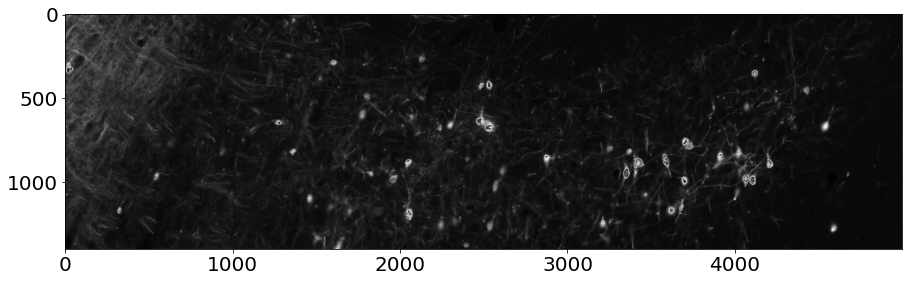

In [63]:
vimg=img[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(5*vimg)

<Figure size 1080x1080 with 0 Axes>

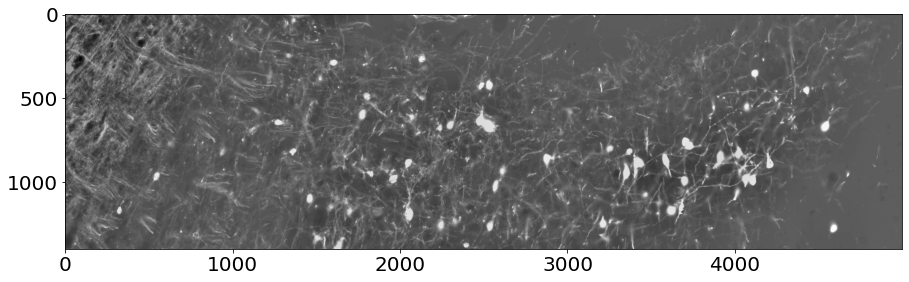

In [64]:
diff=S-relarge
plt.figure(figsize=[15,15])
show_image(diff[in_row_min:in_row_max, in_col_min: in_col_max]);

<Figure size 1080x1080 with 0 Axes>

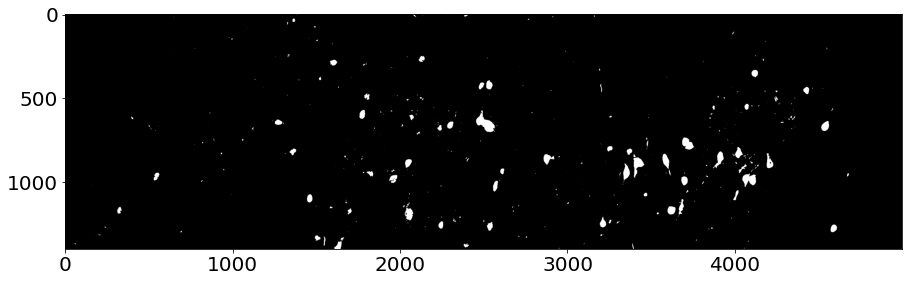

In [71]:
plt.figure(figsize=[15,15])
vdiff=diff[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(vdiff>150);

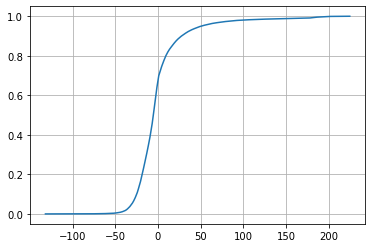

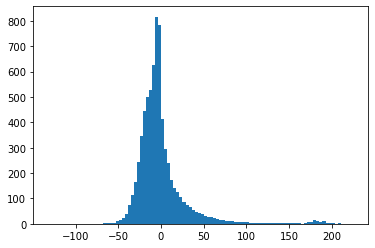

In [72]:
plot_dist(diff[in_row_min:in_row_max, in_col_min: in_col_max])

In [168]:
Stats=cv2.connectedComponentsWithStats(np.int8(diff>130))
Stats[0]

1428

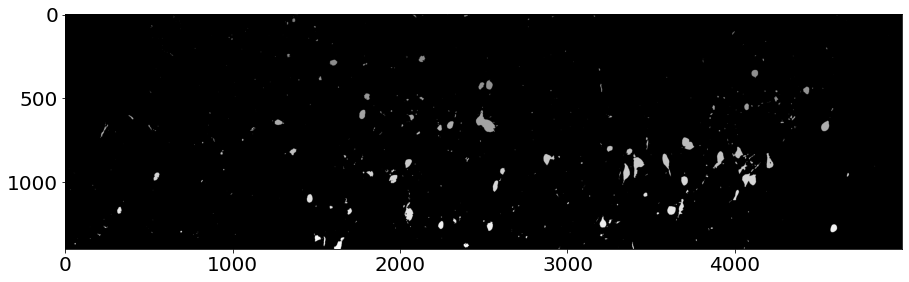

In [169]:
show_image(Stats[1][in_row_min:in_row_max, in_col_min: in_col_max])

In [170]:
Stats[2].shape, Stats[3].shape

((1428, 5), (1428, 2))

In [183]:
candid_coor=np.int32(Stats[3])
min_row,min_col = origins[tile]
candid_coor

array([[15004,  3397],
       [12054,   132],
       [ 2700,  1285],
       ...,
       [11306,  6788],
       [12057,  6793],
       [10951,  6796]], dtype=int32)

In [184]:
pos_coor=np.int32(df[['y','x']])
pos_coor -= np.array([min_row,min_col])
pos_coor.shape

(115, 2)

In [185]:
from numpy.linalg import norm
Dists=[]
for i in range(len(candid_coor)):
    c=norm(pos_coor-candid_coor[i],axis=1)
    Dists.append((i,np.min(c),np.argmin(c)))
Dists

[(0, 6883.693340060988, 2),
 (1, 7221.1135567861, 80),
 (2, 4803.230995902654, 83),
 (3, 5106.931074529986, 80),
 (4, 5095.394489144093, 80),
 (5, 4619.7745615993, 83),
 (6, 4787.012116132567, 80),
 (7, 4780.604982635566, 80),
 (8, 5207.772076425772, 80),
 (9, 4458.685905062163, 80),
 (10, 4678.404001366278, 80),
 (11, 4453.217263956476, 80),
 (12, 5222.061853329583, 80),
 (13, 5210.4004644556835, 80),
 (14, 5206.965527060843, 80),
 (15, 5608.956409172743, 80),
 (16, 5449.7732980372675, 80),
 (17, 4988.958708989282, 80),
 (18, 4410.929720591794, 80),
 (19, 4649.097224193101, 80),
 (20, 4399.112296816256, 80),
 (21, 4423.491155185008, 80),
 (22, 5060.805469488034, 80),
 (23, 4411.83068578113, 80),
 (24, 4302.665801569999, 80),
 (25, 4296.836627101384, 80),
 (26, 4980.424479901287, 80),
 (27, 4998.182569694709, 80),
 (28, 4990.70215500785, 80),
 (29, 4419.296776637659, 80),
 (30, 4333.031848486692, 80),
 (31, 3954.1705830679584, 80),
 (32, 4233.360131148778, 80),
 (33, 4081.805972850743,

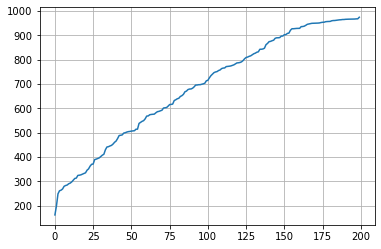

In [186]:
SD=np.sort([d[1] for d in Dists])
plt.plot(SD[:200])
plt.grid()

In [153]:
candid_coor.shape,pos_coor.shape

((1428, 2), (115, 2))

In [154]:
seg=Stats[1]
seg.shape

(6800, 30000)

In [164]:
for i in range(len(pos_coor)):
    c=pos_coor[i]-np.array([min_col,min_row])
    if c[0]<0 or c[0]>=tile_height or c[1]<0 or c[1] >=tile_width:
        continue
    print(np.array([min_col,min_row]),c)
    print(i,seg[c[0],c[1]])

[30000 13600] [5491 7214]
80 0
[30000 13600] [5928 6556]
81 0
[30000 13600] [5852 6214]
82 0
[30000 13600] [5793 4358]
83 0
[30000 13600] [6061 5566]
84 0


In [163]:
tile_width,tile_height

(30000, 6800)